## Generating point cloud

DO NOT RUN if results are already present, as it takes 40 minutes

In [ ]:
from pyodm import Node
from os import listdir, path

In [ ]:
n = Node('localhost', 3000)

In [ ]:
prefix = '../images/original'
files = [path.sep.join([prefix, f]) for f in listdir(prefix)]

In [ ]:
task = n.create_task(files, {'dsm': True})
task.wait_for_completion()

In [ ]:
task.download_assets("/media/antonio/Ubuntail/Dropbox/education/phd/courses/processamento_imagens/assignments/final/pyodm")

## Visualizing point cloud

In [7]:
import laspy
import open3d as o3d
import numpy as np
from os import listdir, path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
pc_data_dir = '/media/antonio/Ubuntail/Dropbox/education/phd/courses/processamento_imagens/assignments/final/pyodm/entwine_pointcloud/ept-data'

In [9]:
points = None
for fname in listdir(pc_data_dir):
    pc = laspy.read(path.sep.join([pc_data_dir, fname]))
    point_data = np.stack([pc.X, pc.Y, pc.Z], axis=0).transpose((1, 0))
    if points is None:
        points = point_data
    else:
        points = np.concatenate([points, point_data])
points -= np.min(points, axis=0)
points = points.astype(np.float32)       

In [11]:
surface = o3d.geometry.PointCloud()
surface.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([surface])

## Generate Depth-Map from Point-Cloud

In [1]:
from point_cloud import get_depth_map
import matplotlib.pyplot as plt

In [3]:
def show(img, plt_size=(16, 10), cmap=None):
    fig = plt.figure(figsize=plt_size)
    plt.imshow(img, cmap=(cmap
                          if cmap is not None
                          else (None if len(img.shape) == 3 else 'gray')))

In [5]:
depth_map = get_depth_map(pc_data_dir, (500, 625))

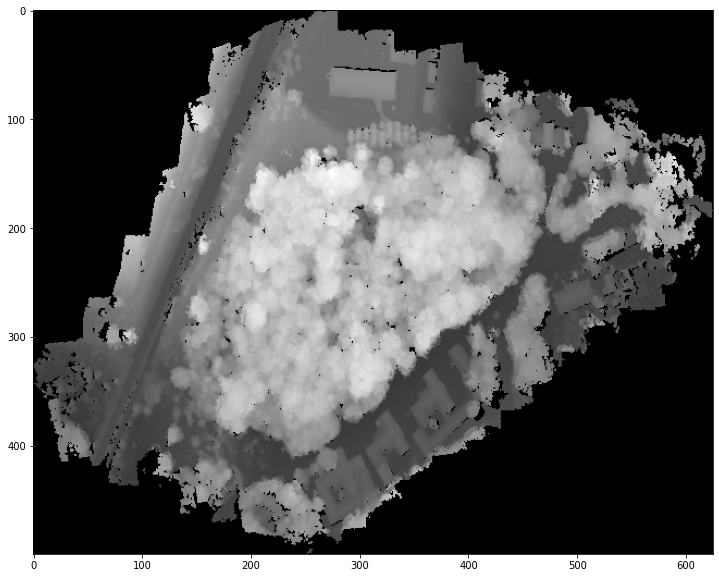

In [6]:
show(depth_map)

## Segmentation Using Depth Map

In [30]:
from point_cloud import get_depth_map
from morph_texture import normalize
import matplotlib.pyplot as plt
import numpy as np
from os import listdir, path
import imageio
import cv2
from skimage.morphology import disk


In [2]:
base_dir = '/media/antonio/Ubuntail/Dropbox/education/phd/courses/processamento_imagens/assignments/final'
main_img_path = path.sep.join([base_dir, 'images', 'mataDS.tif'])

p_cloud_dir = path.sep.join([base_dir, 'pyodm', 'entwine_pointcloud', 'ept-data'])

In [5]:
downscaling = 8
main_img = cv2.imread(main_img_path)
main_img = cv2.resize(main_img, (main_img.shape[1] // downscaling, main_img.shape[0] // downscaling))
resolution = main_img.shape[:2]

(2045, 3108)


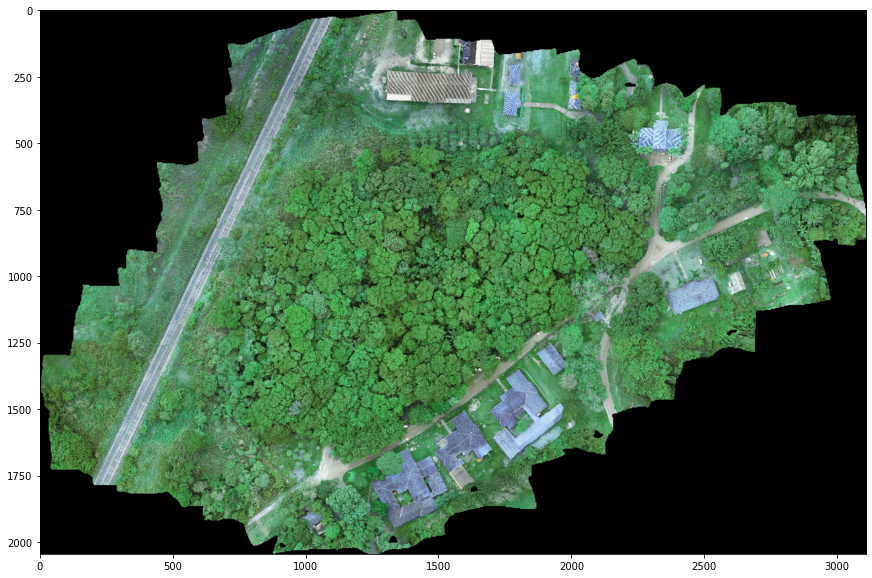

In [8]:
show(main_img)
print(resolution)

In [9]:
depth_map = get_depth_map(p_cloud_dir, resolution)

(2045, 3108)


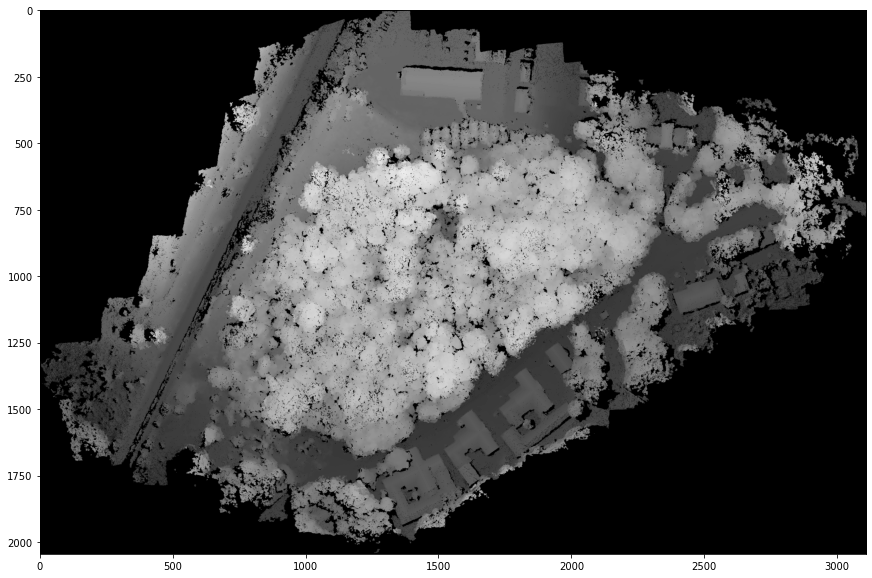

In [10]:
show(depth_map)
print(depth_map.shape)

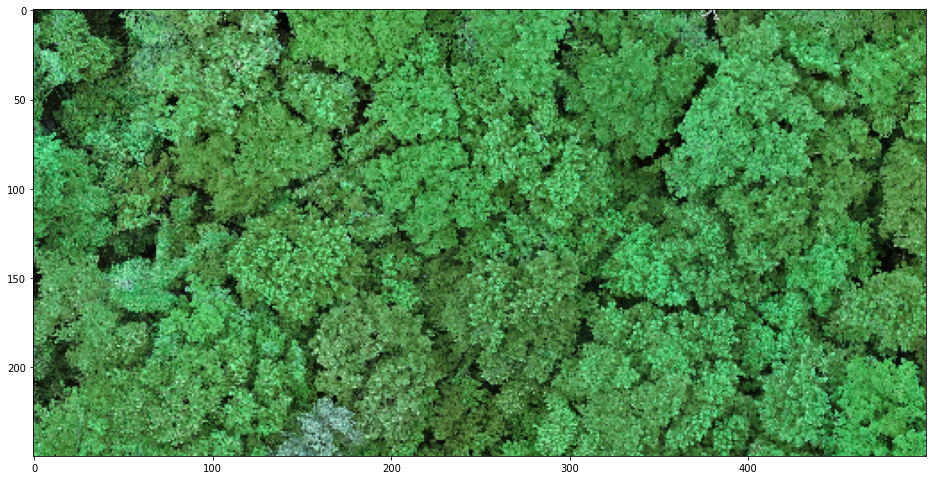

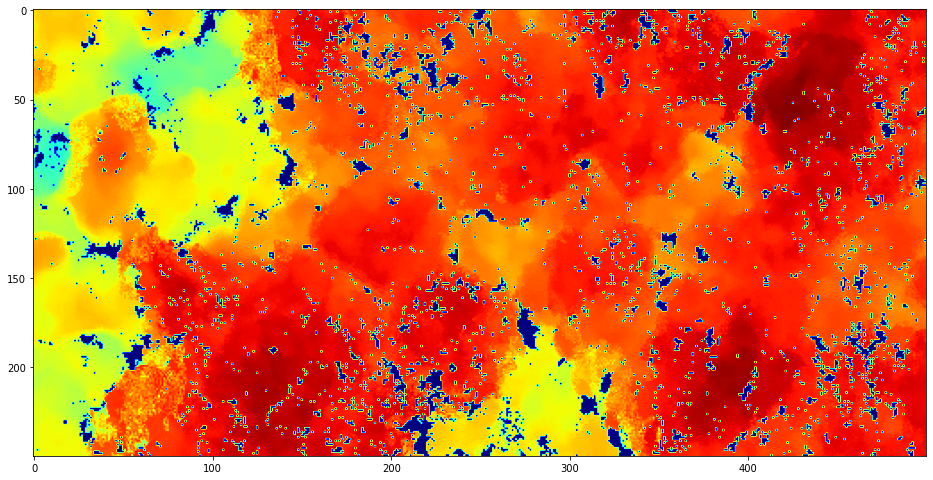

In [92]:
h_head, h_tail = 1250, 1500
w_head, w_tail = 800, 1300

crop_rgb = main_img[h_head:h_tail, w_head:w_tail]
crop_depth = depth_map[h_head:h_tail, w_head:w_tail]

show(crop_rgb)
show(crop_depth, cmap='jet')

In [93]:
np.unique(crop_depth)

array([  0,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198], dtype=uint8)

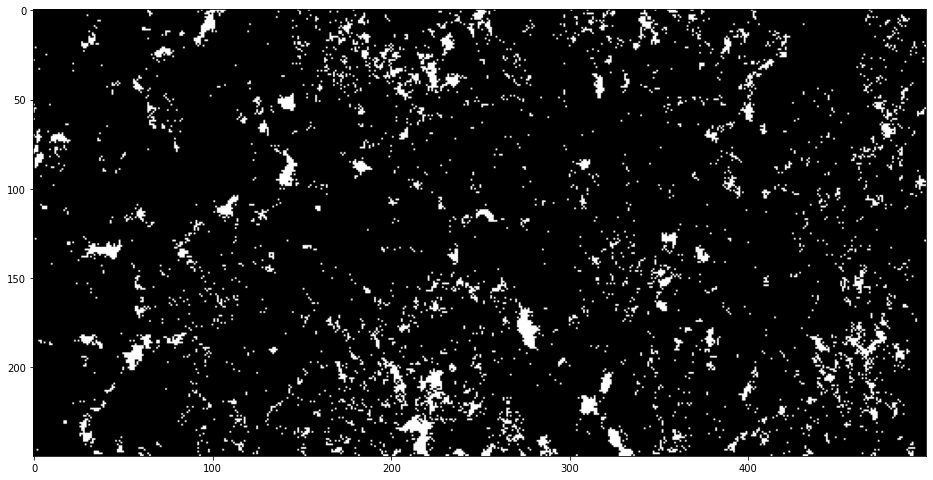

In [94]:
m = np.zeros_like(crop_depth)
m[crop_depth == 0] = 255
show(m)

In [95]:
dilated = cv2.morphologyEx(crop_depth, cv2.MORPH_DILATE, disk(3))

In [96]:
d = normalize(np.clip(dilated, 80, 215), (0, 255), np.uint8)

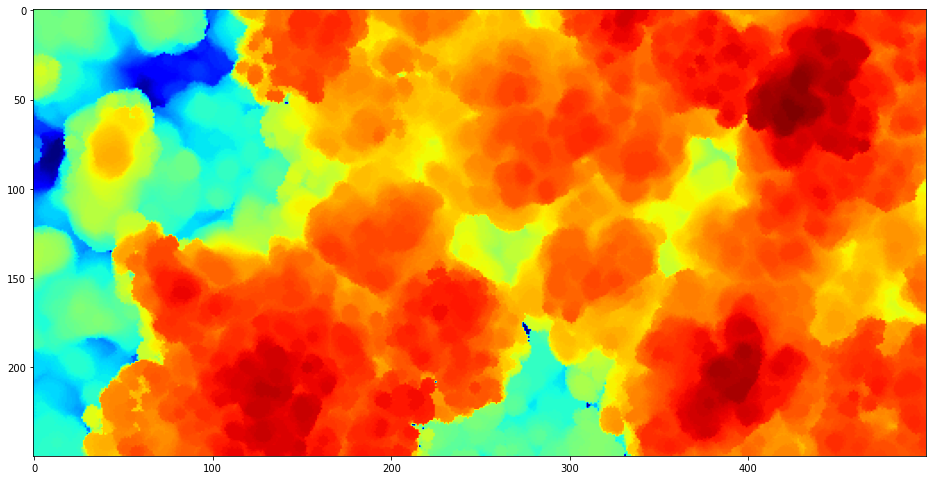

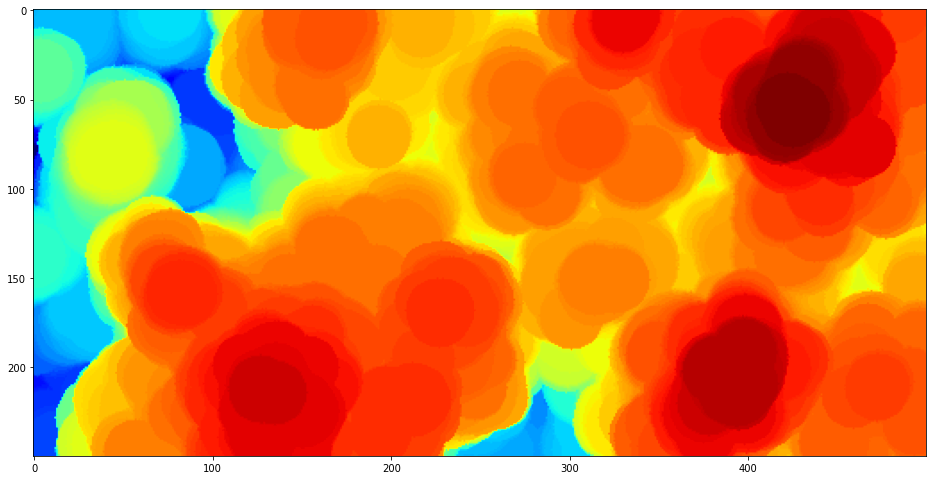

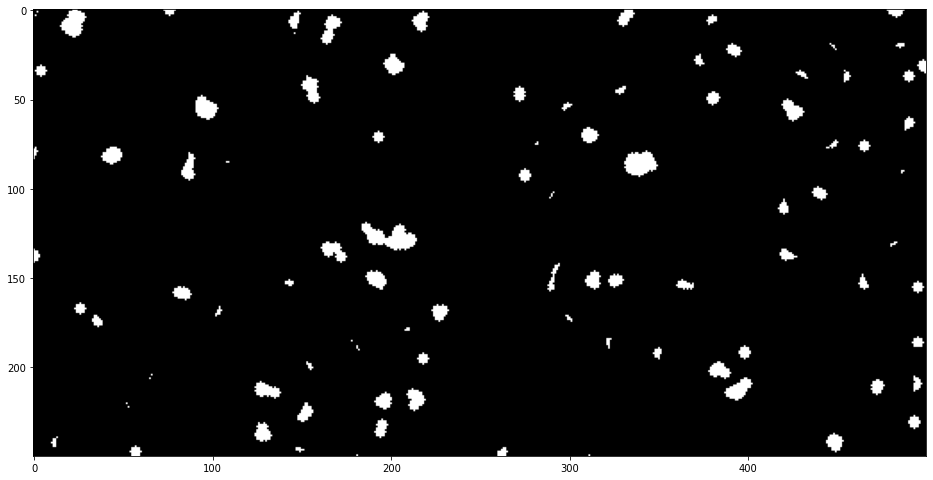

In [97]:
maxima = cv2.morphologyEx(d, cv2.MORPH_DILATE, disk(15))
idxs = np.where(maxima == d)
x= np.zeros_like(d)
x[idxs] = 255
show(d, cmap='jet')
show(maxima, cmap='jet')
show(x)

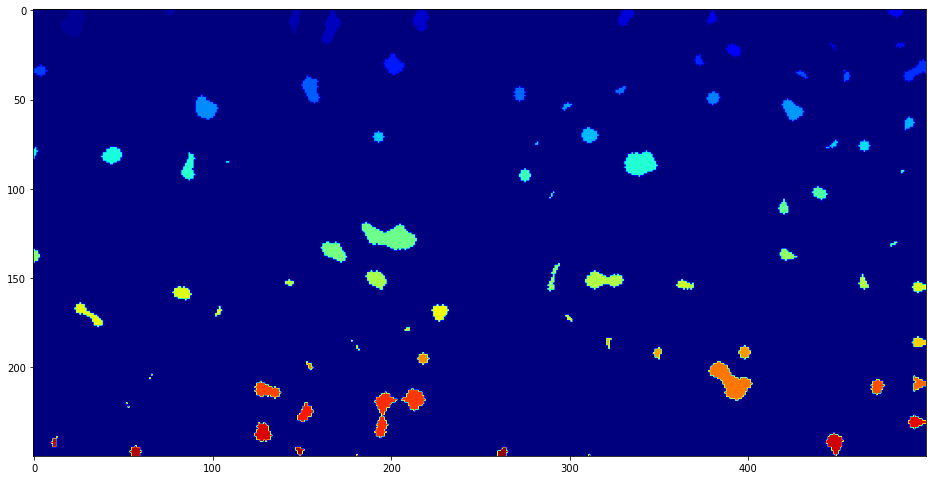

In [98]:
x_open = cv2.morphologyEx(x, cv2.MORPH_CLOSE, disk(3), iterations=2)
conn = cv2.connectedComponents(x_open)[1]
show(conn, cmap='jet')

In [99]:
ws = cv2.watershed(np.max(crop_rgb) - crop_rgb, conn)

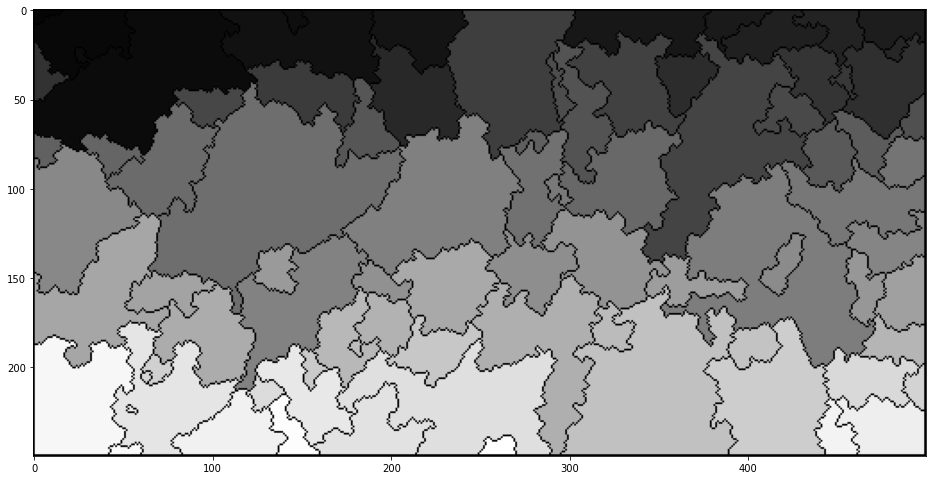

In [103]:
show(ws)

In [112]:
ws_rgb.dtype

dtype('int32')

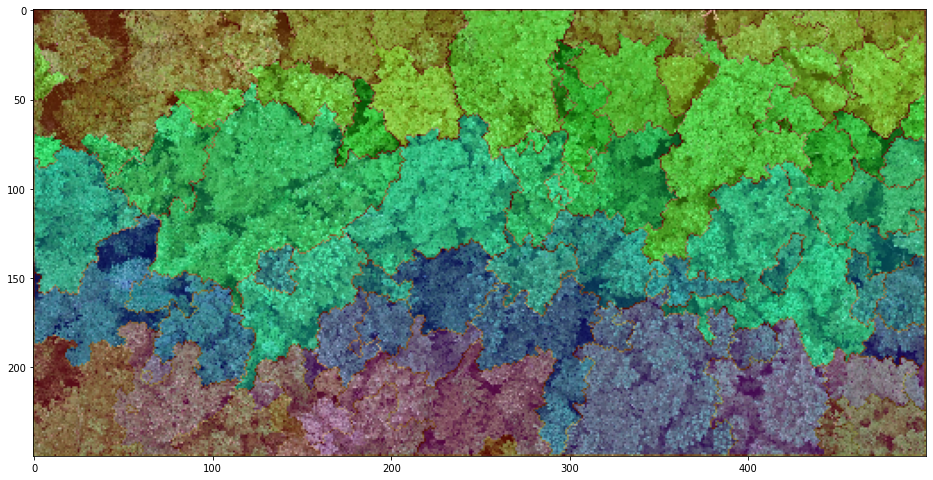

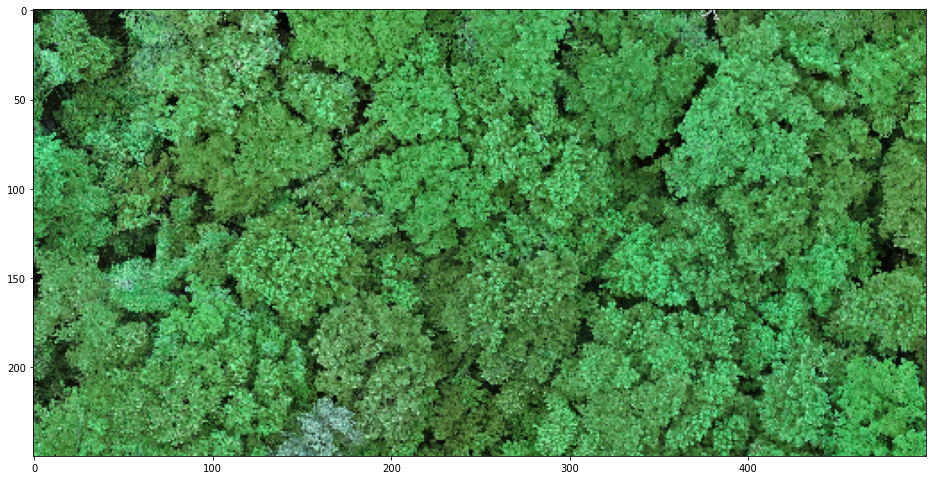

In [116]:
alpha = 0.7


mask = cv2.applyColorMap(normalize(ws, (0, 255), np.uint8), cv2.COLORMAP_HSV)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
blend = cv2.addWeighted(normalize(crop_rgb, (0, 255), np.uint8), alpha, mask, 1 - alpha, 0)
#blend[x_open == 255] = (255, 255, 255)
show(blend)
show(crop_rgb)